# Epidemic Modeling with Epydemix

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ngozzi/tech-transfer-epdemix/blob/main/sessions/session-3/python/01_modeling_tutorial.ipynb)

This tutorial walks through building an age-structured SEIR model, running simulations with real population data, and comparing intervention scenarios.

**What you'll learn:**
- Define compartmental models and transitions from scratch
- Load population data and contact matrices for 400+ geographies
- Run stochastic simulations and visualize results
- Model non-pharmaceutical interventions and compare scenarios
- Simulate vaccination campaigns with custom transition functions

In [1]:
# Colab installation (skip if running locally)
import sys, os, subprocess
if "google.colab" in sys.modules or os.getenv("COLAB_RELEASE_TAG"):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-r",
                    "https://raw.githubusercontent.com/epistorm/epydemix/refs/heads/main/tutorials/colab_requirements.txt"])

---
## 1. Building an SEIR Model from Scratch

Compartmental models divide the population into states. The **SEIR model** has four:

- **S** (Susceptible): Can be infected
- **E** (Exposed): Infected but not yet infectious (latent period)
- **I** (Infectious): Can transmit the disease
- **R** (Recovered): Immune

Transitions between compartments are either:
- **Mediated**: Depends on interactions (S→E requires contact with I)
- **Spontaneous**: Happens at a fixed rate (E→I, I→R)

In [2]:
from epydemix import EpiModel

# Create the model with four compartments
model = EpiModel(
    name="SEIR Model",
    compartments=["S", "E", "I", "R"]
)

# Add transitions
# S → E: mediated by contact with infectious individuals (rate β)
model.add_transition(source="S", target="E", params=("beta", "I"), kind="mediated")

# E → I: spontaneous at rate σ (1/latent period)
model.add_transition(source="E", target="I", params="sigma", kind="spontaneous")

# I → R: spontaneous at rate γ (1/infectious period)
model.add_transition(source="I", target="R", params="gamma", kind="spontaneous")

# Set parameter values
model.add_parameter("beta", 0.035)   # transmission rate
model.add_parameter("sigma", 0.2)   # 1/5 days latent period
model.add_parameter("gamma", 0.1)   # 1/10 days infectious period

print(model)

EpiModel(name='SEIR Model')
Compartments: 4
  S, E, I, R
Transitions: 3
  Transitions between compartments:
    S -> E, params: ('beta', 'I') (kind: mediated)
    E -> I, params: sigma (kind: spontaneous)
    I -> R, params: gamma (kind: spontaneous)
Parameters: 3
  Model parameters:
    beta: 0.035
    sigma: 0.2
    gamma: 0.1
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



---
## 2. Loading Population Data

Epydemix includes demographic data and synthetic contact matrices for 400+ regions worldwide. Let's load data for **United States**.

The `Population` object contains:
- **Population distribution** by age group
- **Contact matrices** for different settings (home, school, work, community)

You can see all supported locations [here](https://github.com/epistorm/epydemix-data/blob/main/locations.csv).

In [3]:
from epydemix.population import load_epydemix_population

# Load US population data
population = load_epydemix_population("United_States")
print(population)

Population(name='United_States')
Demographic groups: 5 groups
Population distribution:
  - 0-4: 18608139 individuals
  - 5-19: 63540783 individuals
  - 20-49: 132780169 individuals
  - 50-64: 63172279 individuals
  - 65+: 60019216 individuals
Contact matrices: 4 layers
Available layers:
  - school
  - work
  - home
  - community



Let's attach the population to our model before moving on.

In [4]:
model.set_population(population)

### Exploring the Population

Let's visualize the age distribution and contact patterns.

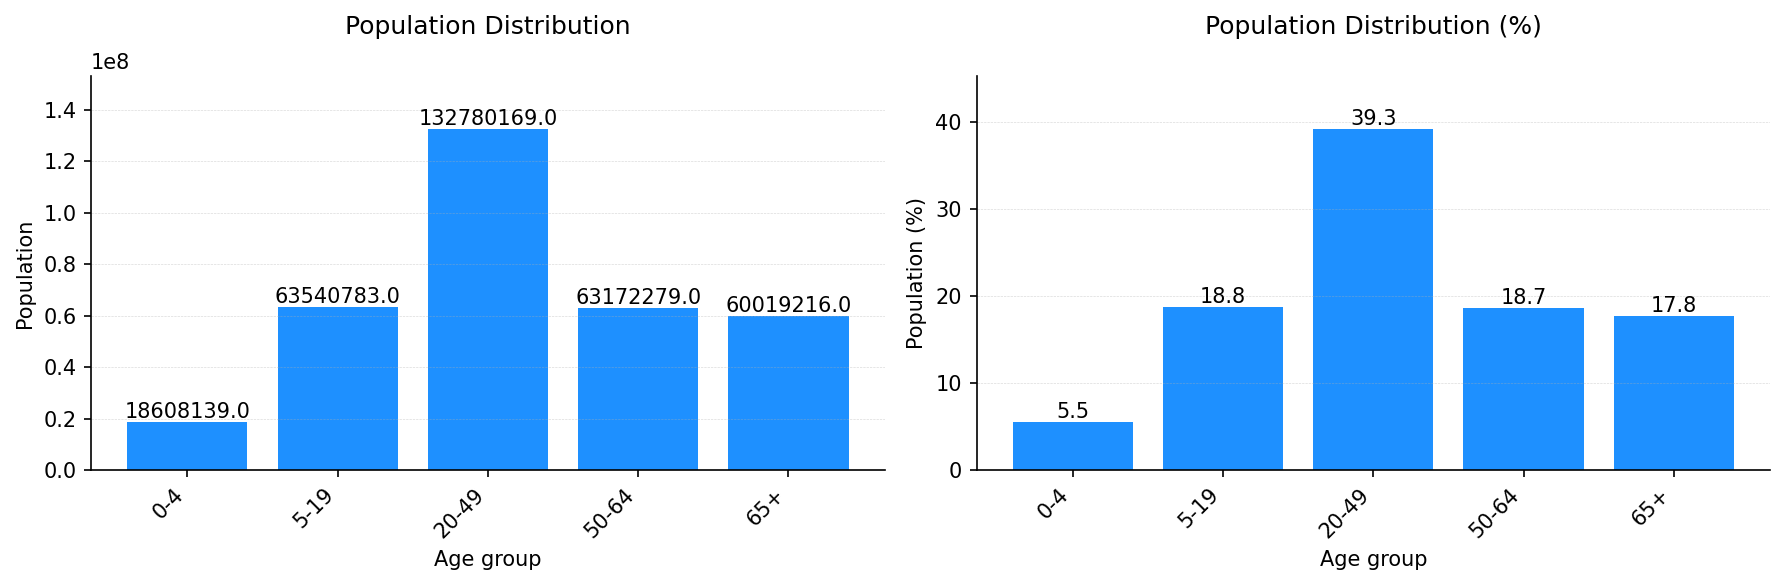

In [5]:
from epydemix.visualization import plot_contact_matrix, plot_population
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=150)

# Population pyramid
plot_population(population, ax=axes[0], title="Population Distribution")

# Population percentages
plot_population(population, ax=axes[1], title="Population Distribution (%)", show_perc=True)

plt.tight_layout()

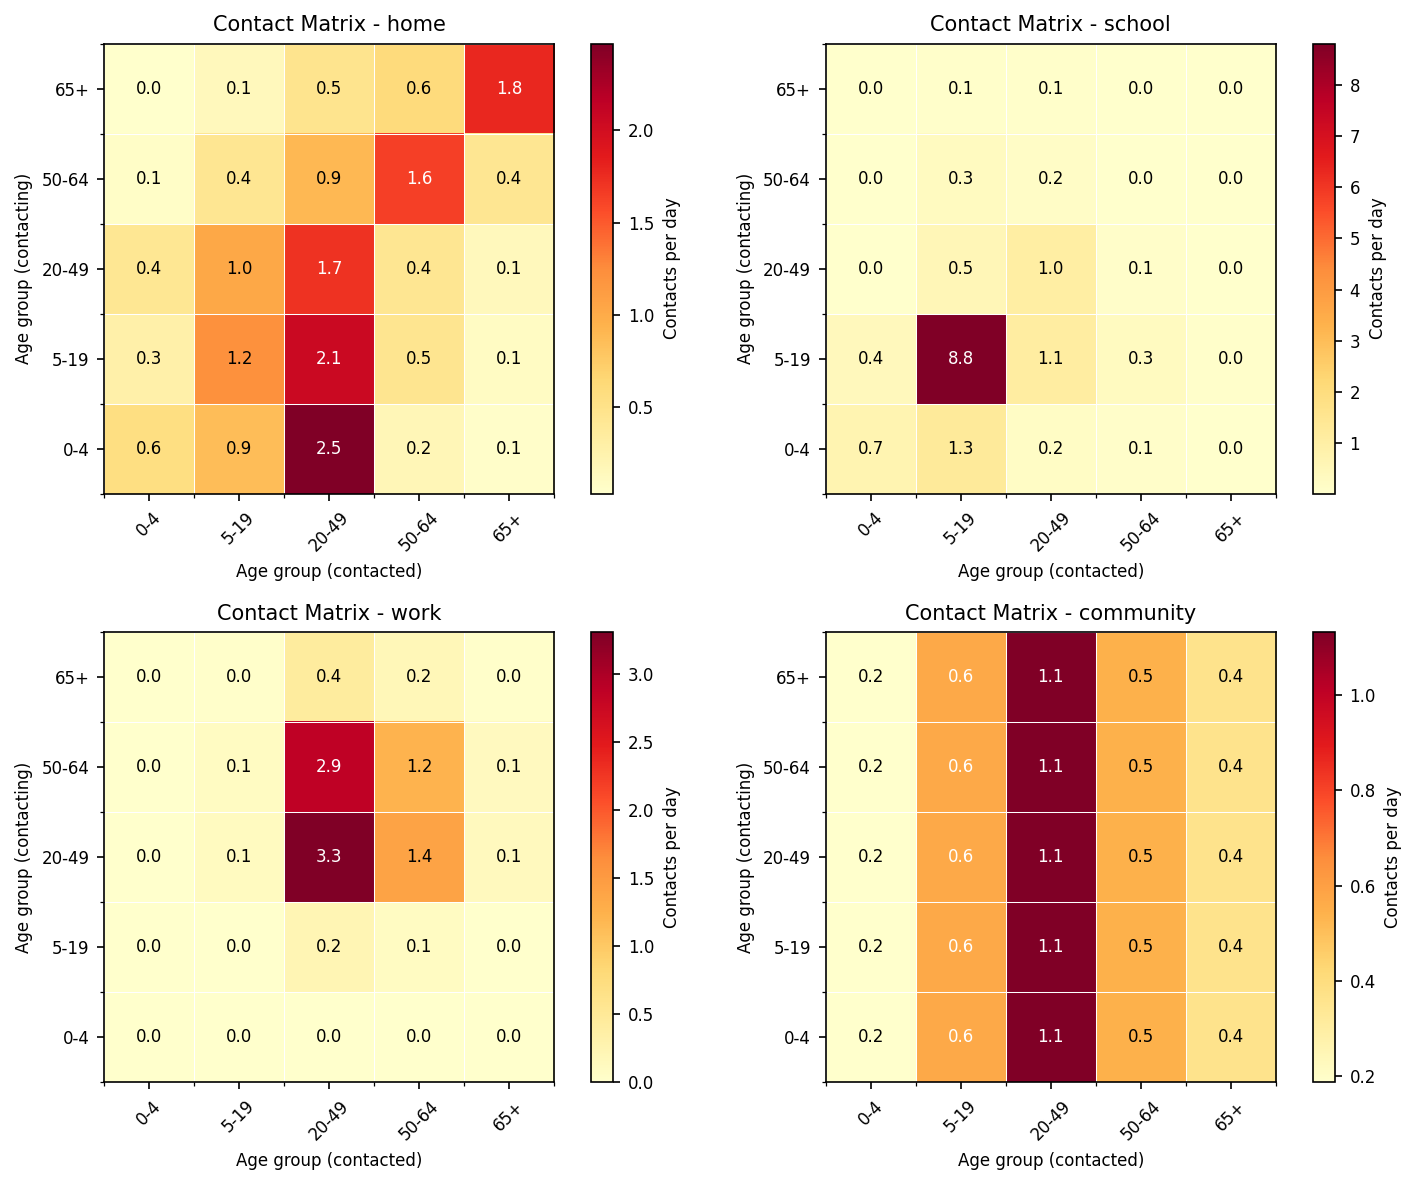

In [6]:
# Contact matrices by setting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), dpi=150)

for ax, layer in zip(axes.flatten(), ["home", "school", "work", "community"]):
    plot_contact_matrix(population, layer, ax=ax, fontsize=8, show_values=True)

plt.tight_layout()

**Reading contact matrices:** Each cell $(i, j)$ shows the average daily contacts that a person in age group $i$ has with people in age group $j$. Notice how:
- **School** contacts are concentrated among children (5-19)
- **Work** contacts peak in working-age adults (20-64)
- **Home** contacts show intergenerational mixing
- **Community** contacts are more diffuse

### What is the Model $R_0$?

The reproduction number $R_0$ is the average number of people an infected person will infect. For the SEIR model on an age-structured population, it can be computed as:    

$$
R_0 = \frac{\beta}{\gamma} \rho(C)
$$

Where $\rho(C)$ is the spectral radius (i.e., the largest eigenvalue) of the contact matrix $C$, $\beta$ is the transmission rate, and $\gamma$ is the recovery rate. The spectral radius is a measure of the "intensity" of contacts in the population: higher values mean that there are more contacts, and therefore more opportunities for transmission. In other words, $R_0$ is the product of the average number of people an infected person will infect per unit of time and the average duration of the infectious period. In our case, $R_0$ can be computed as:




In [7]:
import numpy as np

# Get overall contact matrix as sum of individual matrices and compute spectral radius
C = np.sum(list(model.population.contact_matrices.values()), axis=0)
rho = np.linalg.eigvals(C).real.max()  

# Compute R0
R0 = model.parameters["beta"] / model.parameters["gamma"] * rho
print(f"R0: {R0:.2f}")

R0: 4.91


---
## 3. Running Simulations

Epydemix uses **stochastic chain-binomial** simulations. Each run produces a different trajectory due to randomness—we run many simulations to capture uncertainty.

Let's run simulations.

In [8]:
# Run 100 stochastic simulations
results = model.run_simulations(
    start_date="2026-01-01",
    end_date="2026-08-31",
    Nsim=25,
    percentage_in_agents=10 / population.Nk.sum()  # seed with 20 infected
)

### Visualizing Results

The `SimulationResults` object provides methods to extract compartment counts and transitions over time.

<Axes: title={'center': 'SEIR Epidemic Trajectory'}>

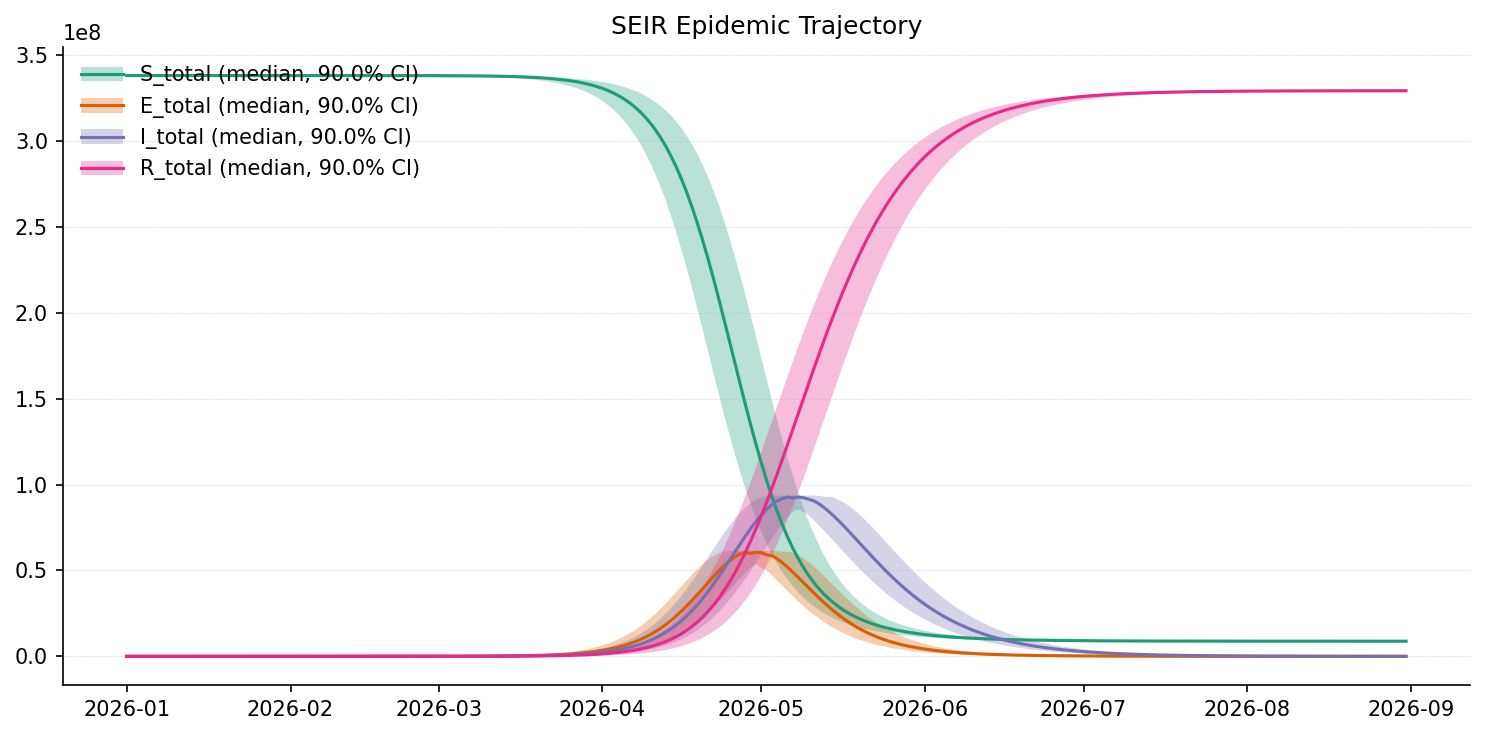

In [9]:
from epydemix.visualization import plot_quantiles

# Get quantiles (median, 25th, 75th percentiles) across simulations
df_quantiles = results.get_quantiles_compartments()

# Plot all compartments
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
plot_quantiles(df_quantiles, columns=["S_total", "E_total", "I_total", "R_total"], 
               title="SEIR Epidemic Trajectory", ax=ax)

<Axes: title={'center': 'Infections by Age Group'}>

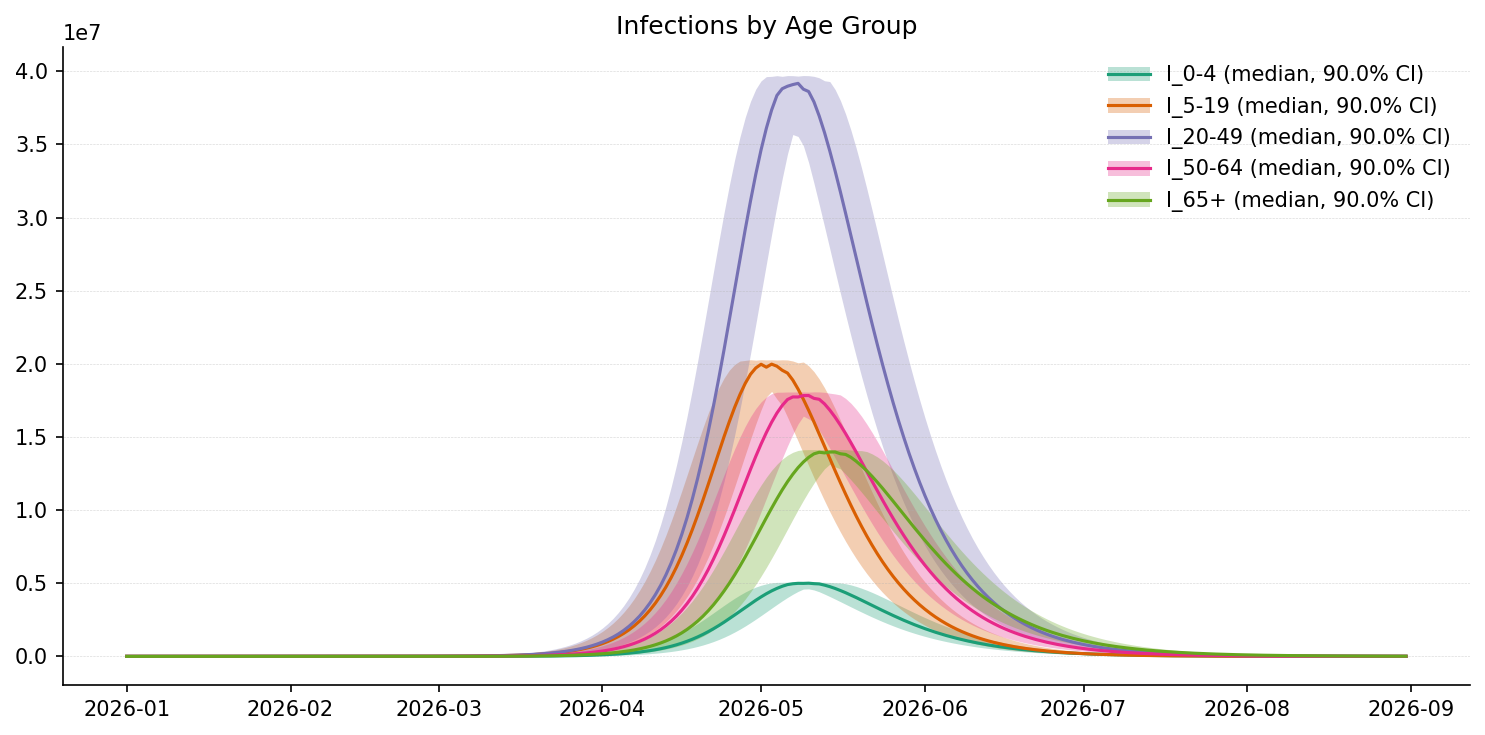

In [10]:
# Infections by age group
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
plot_quantiles(df_quantiles, 
               columns=["I_0-4", "I_5-19", "I_20-49", "I_50-64", "I_65+"],
               title="Infections by Age Group", ax=ax, legend_loc="upper right")

<Axes: title={'center': 'Individual Simulation Trajectories (Infected)'}>

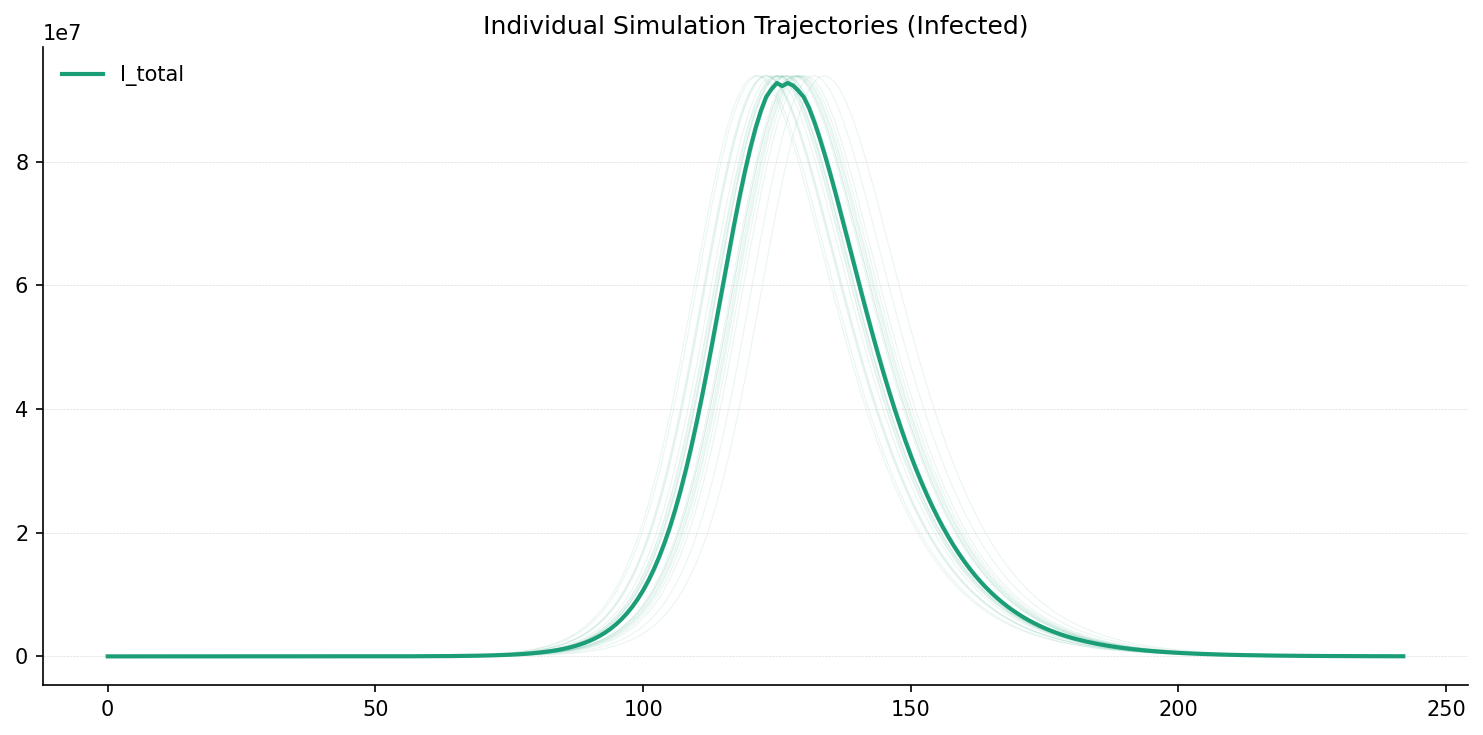

In [11]:
from epydemix.visualization import plot_trajectories

# Show individual simulation trajectories
trajectories = results.get_stacked_compartments()
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
plot_trajectories(trajectories, columns=["I_total"], 
                  title="Individual Simulation Trajectories (Infected)", ax=ax)

---
## 4. Modeling Interventions

Non-pharmaceutical interventions (NPIs) reduce transmission by limiting contacts. Epydemix supports two approaches:

1. **`add_intervention`**: Reduce contacts in specific settings (school closure, work-from-home)
2. **`override_parameter`**: Modify transmission parameters directly (masking, social distancing)

Let's compare a baseline scenario to one with interventions.

In [12]:
# Create three identical SEIR models for comparison
def create_seir_model():
    m = EpiModel(name="SEIR", compartments=["S", "E", "I", "R"])
    m.add_transition(source="S", target="E", params=("beta", "I"), kind="mediated")
    m.add_transition(source="E", target="I", params="sigma", kind="spontaneous")
    m.add_transition(source="I", target="R", params="gamma", kind="spontaneous")
    m.add_parameter("beta", 0.035)
    m.add_parameter("sigma", 0.2)
    m.add_parameter("gamma", 0.1)
    m.set_population(population)
    return m

model_baseline = create_seir_model()
model_contact_intervention = create_seir_model()
model_transmission_intervention = create_seir_model()

In [13]:
# Model 2: Contact interventions (school closure + work-from-home)

# School closure: 70% reduction in school contacts (Apr 1 - Aug 31)
model_contact_intervention.add_intervention(
    layer_name="school",
    start_date="2026-04-01",
    end_date="2026-08-31",
    reduction_factor=0.3,  # 70% reduction
    name="school closure"
)

# Work-from-home: 50% reduction in work contacts (Apr 1 - Aug 31)
model_contact_intervention.add_intervention(
    layer_name="work",
    start_date="2026-04-01",
    end_date="2026-08-31",
    reduction_factor=0.5,  # 50% reduction
    name="work from home"
)

# Model 3: Transmission reduction (e.g., masking, social distancing)
# Reduces beta by ~30% during the intervention period
model_transmission_intervention.override_parameter(
    start_date="2026-04-01",
    end_date="2026-08-31",
    parameter_name="beta",
    value=0.025  # reduced from 0.035
)

### Visualizing Intervention Impact on Contacts

The **spectral radius** of the contact matrix is proportional to $R_0$. We can visualize how interventions reduce it over time.

Text(0.5, 1.0, 'Contact Intervention: Change in Spectral Radius')

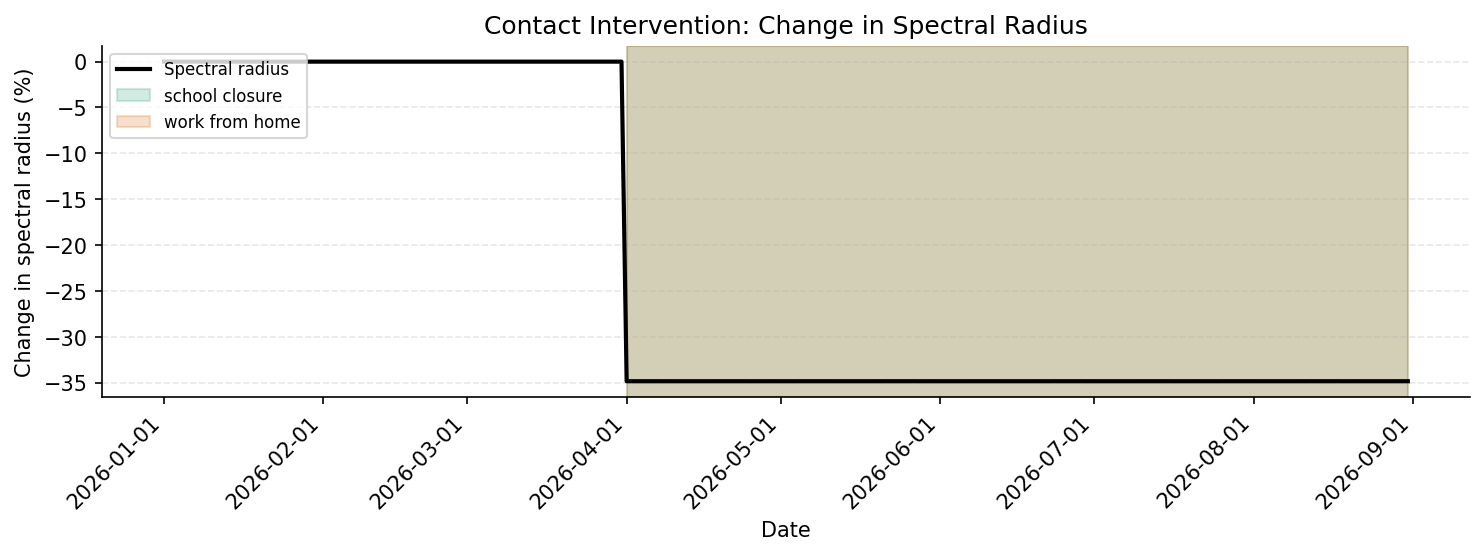

In [14]:
from epydemix.visualization import plot_spectral_radius
from epydemix.utils import compute_simulation_dates

# Compute contact reductions for visualization
simulation_dates = compute_simulation_dates("2026-01-01", "2026-08-31")
model_contact_intervention.compute_contact_reductions(simulation_dates)

# Plot spectral radius change
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)
plot_spectral_radius(model_contact_intervention, show_perc=True, ax=ax)
ax.set_title("Contact Intervention: Change in Spectral Radius")

### Comparing Scenarios

In [15]:
# Run all three scenarios
sim_params = dict(
    start_date="2026-01-01",
    end_date="2026-08-31",
    Nsim=25,
    percentage_in_agents=10 / population.Nk.sum()
)

results_baseline = model_baseline.run_simulations(**sim_params)
results_contact = model_contact_intervention.run_simulations(**sim_params)
results_transmission = model_transmission_intervention.run_simulations(**sim_params)

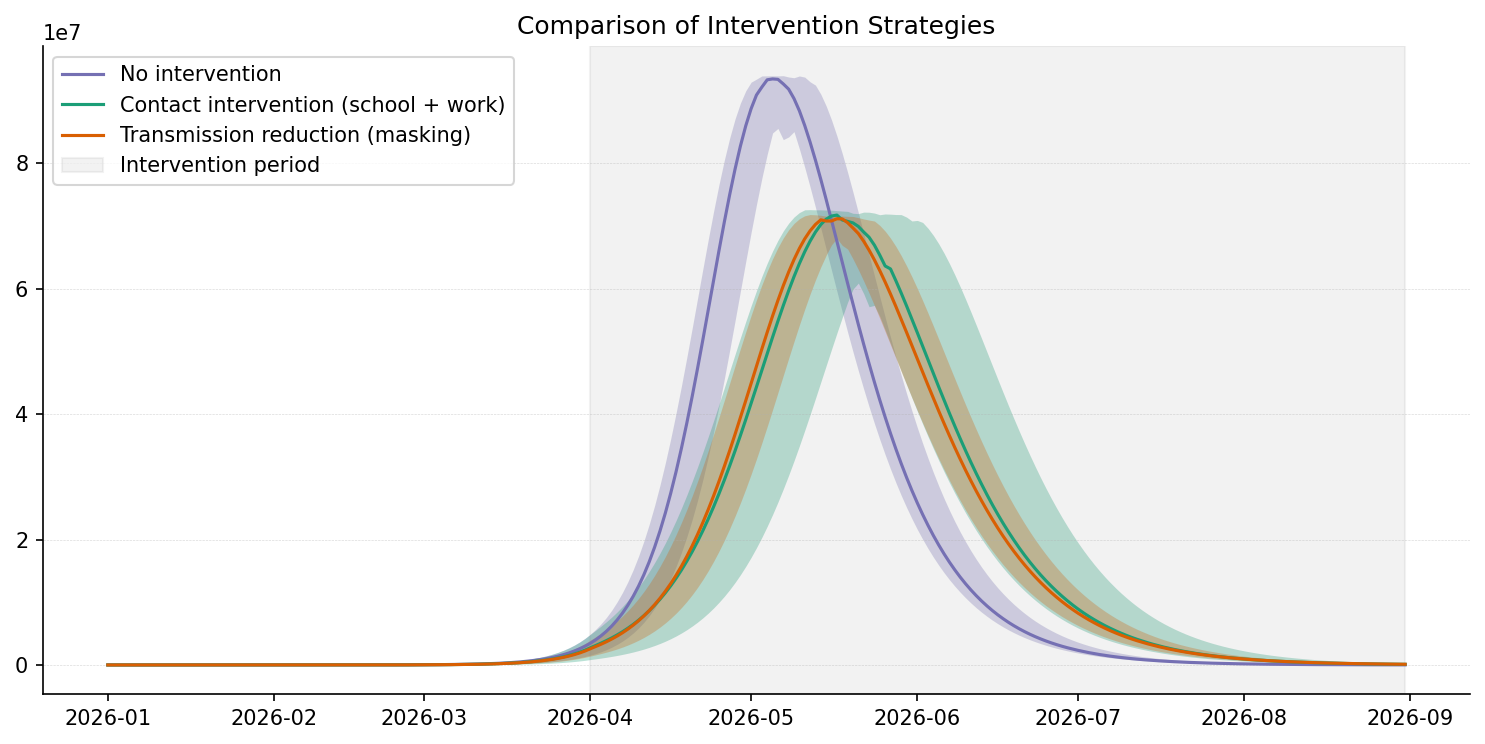

In [16]:
import seaborn as sns
colors = sns.color_palette("Dark2")

fig, ax = plt.subplots(figsize=(10, 5), dpi=150)

# Plot baseline
df_baseline = results_baseline.get_quantiles_compartments()
plot_quantiles(df_baseline, columns=["I_total"], colors=colors[2], 
               labels="No intervention", ax=ax)

# Plot contact intervention scenario
df_contact = results_contact.get_quantiles_compartments()
plot_quantiles(df_contact, columns=["I_total"], colors=colors[0],
               labels="Contact intervention (school + work)", ax=ax)

# Plot transmission intervention scenario
df_transmission = results_transmission.get_quantiles_compartments()
plot_quantiles(df_transmission, columns=["I_total"], colors=colors[1],
               labels="Transmission reduction (masking)", ax=ax)

ax.set_title("Comparison of Intervention Strategies")
ax.axvspan("2026-04-01", "2026-08-31", alpha=0.1, color="gray", label="Intervention period")
ax.legend()

### Quantifying Impact

Let's calculate the reduction in total infections and peak size.

In [17]:
import numpy as np

# Get full trajectories
traj_baseline = results_baseline.get_stacked_compartments()
traj_contact = results_contact.get_stacked_compartments()
traj_transmission = results_transmission.get_stacked_compartments()

# Total infections (final recovered count)
total_baseline = traj_baseline["R_total"][:, -1]
total_contact = traj_contact["R_total"][:, -1]
total_transmission = traj_transmission["R_total"][:, -1]

averted_contact = (total_baseline - total_contact) / total_baseline * 100
averted_transmission = (total_baseline - total_transmission) / total_baseline * 100

# Peak infections
peak_baseline = traj_baseline["I_total"].max(axis=1)
peak_contact = traj_contact["I_total"].max(axis=1)
peak_transmission = traj_transmission["I_total"].max(axis=1)

peak_reduction_contact = (peak_baseline - peak_contact) / peak_baseline * 100
peak_reduction_transmission = (peak_baseline - peak_transmission) / peak_baseline * 100

print("Contact intervention (school + work):")
print(f"  Infections averted: {np.median(averted_contact):.1f}% (IQR: {np.percentile(averted_contact, 25):.1f}–{np.percentile(averted_contact, 75):.1f}%)")
print(f"  Peak reduction: {np.median(peak_reduction_contact):.1f}% (IQR: {np.percentile(peak_reduction_contact, 25):.1f}–{np.percentile(peak_reduction_contact, 75):.1f}%)")
print()
print("Transmission reduction (masking):")
print(f"  Infections averted: {np.median(averted_transmission):.1f}% (IQR: {np.percentile(averted_transmission, 25):.1f}–{np.percentile(averted_transmission, 75):.1f}%)")
print(f"  Peak reduction: {np.median(peak_reduction_transmission):.1f}% (IQR: {np.percentile(peak_reduction_transmission, 25):.1f}–{np.percentile(peak_reduction_transmission, 75):.1f}%)")

Contact intervention (school + work):
  Infections averted: 2.8% (IQR: 2.8–2.8%)
  Peak reduction: 22.9% (IQR: 22.8–23.2%)

Transmission reduction (masking):
  Infections averted: 4.6% (IQR: 4.6–4.7%)
  Peak reduction: 23.7% (IQR: 23.7–23.8%)


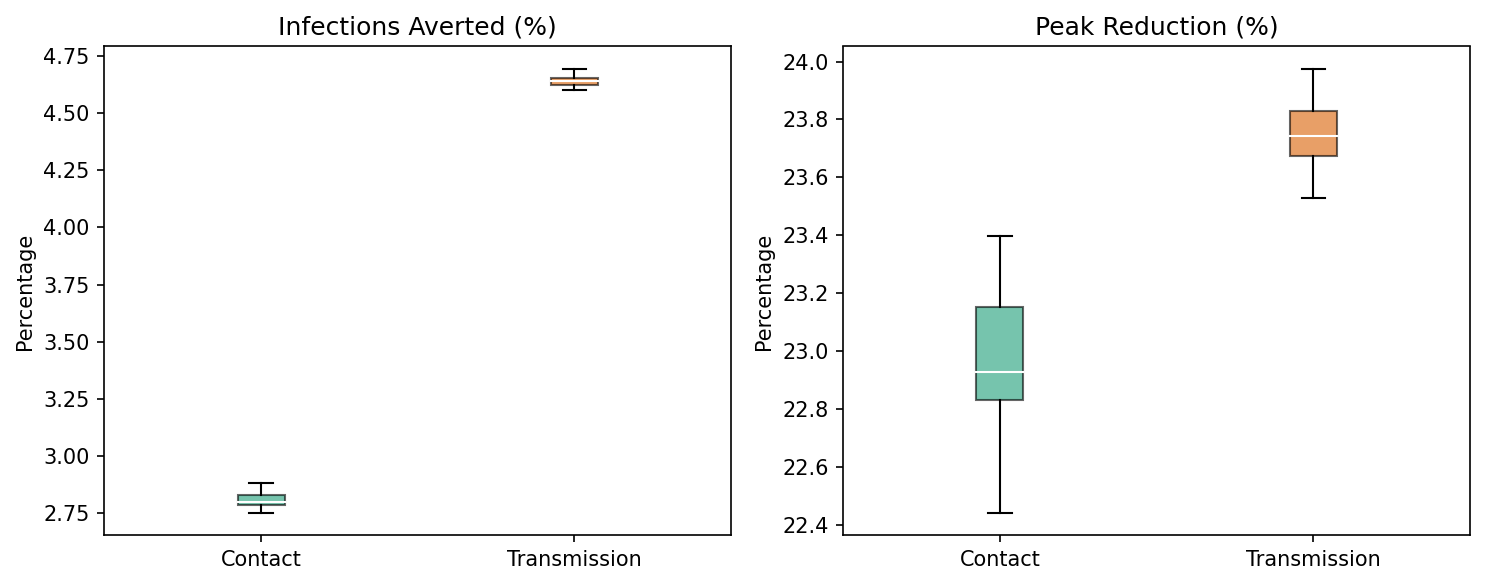

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=150)

# Infections averted
bp1 = axes[0].boxplot([averted_contact, averted_transmission], patch_artist=True,
                       labels=["Contact", "Transmission"],
                       medianprops=dict(color="white"),
                       showfliers=False)
bp1['boxes'][0].set_facecolor(colors[0])
bp1['boxes'][0].set_alpha(0.6)
bp1['boxes'][1].set_facecolor(colors[1])
bp1['boxes'][1].set_alpha(0.6)
axes[0].set_ylabel("Percentage")
axes[0].set_title("Infections Averted (%)")

# Peak reduction
bp2 = axes[1].boxplot([peak_reduction_contact, peak_reduction_transmission], patch_artist=True,
                       labels=["Contact", "Transmission"],
                       medianprops=dict(color="white"),
                       showfliers=False)
bp2['boxes'][0].set_facecolor(colors[0])
bp2['boxes'][0].set_alpha(0.6)
bp2['boxes'][1].set_facecolor(colors[1])
bp2['boxes'][1].set_alpha(0.6)
axes[1].set_ylabel("Percentage")
axes[1].set_title("Peak Reduction (%)")

plt.tight_layout()

---
## 5. Modeling Vaccination Campaigns

Vaccination is a key intervention strategy. In Epydemix, we can model vaccination by:
1. Adding a **vaccinated compartment** (e.g., `SV` for vaccinated susceptibles)
2. Defining a **custom transition** that moves individuals from `S` to `SV` based on daily doses
3. Reducing transmission for vaccinated individuals based on **vaccine effectiveness (VE)**

Let's build an SIR model with vaccination.

### Vaccination Schedule

We'll use a pre-generated vaccination rollout dataset that captures a realistic ramp-up before reaching steady-state capacity. Different age groups receive different prioritization (elderly are prioritized).

In [ ]:
import pandas as pd

# Simulation dates for vaccination scenario
vax_start, vax_end = "2026-01-01", "2026-06-30"

# Load pre-generated vaccination schedule
df_doses = pd.read_csv("../data/vaccination_doses.csv", index_col=0, parse_dates=True)
age_groups = df_doses.columns.tolist()

# Visualize the rollout
df_doses.plot(cmap="Dark2", figsize=(10, 4), ylabel="Daily Vaccine Doses", title="Vaccination Rollout Schedule")

### Defining the Vaccination Transition

To model vaccination, we need a custom transition function. This function computes how many susceptibles get vaccinated each day based on:
- Total doses available
- The fraction of eligible population that is still susceptible (vs. already recovered)

In [23]:
def compute_vaccination_rate(params, data):
    """
    Compute vaccination rate for each age group.
    
    Args:
        params: tuple containing the doses array (doses per day per age group)
        data: dict with population state, compartment indices, and time step
    
    Returns:
        np.array of vaccination rates for each age group
    """
    # Get total doses for today
    total_doses = params[0][data["t"]]
    
    # Compute effective doses: only susceptibles benefit from vaccination
    # (doses given to recovered individuals are "wasted")
    S_pop = data["pop"][data["comp_indices"]["S"]]
    R_pop = data["pop"][data["comp_indices"]["R"]]
    fraction_S = S_pop / (S_pop + R_pop + 1e-10)  # avoid division by zero
    effective_doses = total_doses * fraction_S
    
    # Compute vaccination rate (capped at ~1 to avoid numerical issues)
    rate_vax = np.minimum(effective_doses / (S_pop + 1e-10), 0.999)
    
    return rate_vax

### Building the Model with Vaccination

Now we create an SIR model with an additional `SV` (vaccinated susceptible) compartment. Vaccinated individuals have reduced susceptibility based on vaccine effectiveness (VE).

In [25]:
# Create model with vaccination compartment
model_vax = EpiModel(name="SIR with Vaccination", compartments=["S", "SV", "I", "R"])

# Register the custom vaccination transition
model_vax.register_transition_kind("vaccination", compute_vaccination_rate)

# S + I → 2I (unvaccinated infection)
model_vax.add_transition("S", "I", params=("beta", "I"), kind="mediated")

# SV + I → 2I (vaccinated infection, reduced by VE)
model_vax.add_transition("SV", "I", params=("(1 - VE) * beta", "I"), kind="mediated")

# S → SV (vaccination)
model_vax.add_transition("S", "SV", params=(df_doses[age_groups].values,), kind="vaccination")

# I → R (recovery)
model_vax.add_transition("I", "R", params="gamma", kind="spontaneous")

# Set parameters: 70% vaccine effectiveness
model_vax.add_parameter("beta", 0.02)
model_vax.add_parameter("gamma", 0.1)
model_vax.add_parameter("VE", 0.7)

# Use Utah population (smaller for faster simulation)
pop_utah = load_epydemix_population("United_States_Utah")
model_vax.set_population(pop_utah)

print(model_vax)

EpiModel(name='SIR with Vaccination')
Compartments: 4
  S, SV, I, R
Transitions: 4
  Transitions between compartments:
    S -> I, params: ('beta', 'I') (kind: mediated)
    SV -> I, params: ('(1 - VE) * beta', 'I') (kind: mediated)
    S -> SV, params: (array([[  50,   76,  120,  236,  638],
       [  54,   87,  176,   90,  657],
       [  68,  110,  140,  292, 1112],
       [  33,  148,  164,  257, 1198],
       [  47,  159,  235,  279, 1331],
       [  93,  228,  121,  287,  942],
       [  44,  193,  218,  219, 1413],
       [  14,  285,  282,  139, 1419],
       [  37,  218,  167,  127, 1531],
       [  22,  179,  248,  233, 1589],
       [  42,  248,  224,  356, 1811],
       [  87,  310,  250,  274, 1739],
       [  39,  279,  220,  309, 1986],
       [ 119,  239,  262,  479, 2038],
       [ 110,  347,  345,  350, 1809],
       [  59,  343,  404,  250, 2240],
       [  90,  443,  300,  310, 2364],
       [  50,  391,  321,  380, 2151],
       [  81,  461,  418,  334, 2505],
    

### Running the Vaccination Simulation

In [26]:
# Set initial conditions: 10 infected per age group
n_age_groups = 5
initial_infected = np.ones(n_age_groups) * 10

results_vax = model_vax.run_simulations(
    start_date=vax_start,
    end_date=vax_end,
    Nsim=25,
    initial_conditions_dict={
        "S": pop_utah.Nk - initial_infected,
        "SV": np.zeros(n_age_groups),
        "I": initial_infected,
        "R": np.zeros(n_age_groups)
    }
)

<Axes: title={'center': 'SIR Model with Vaccination Campaign'}>

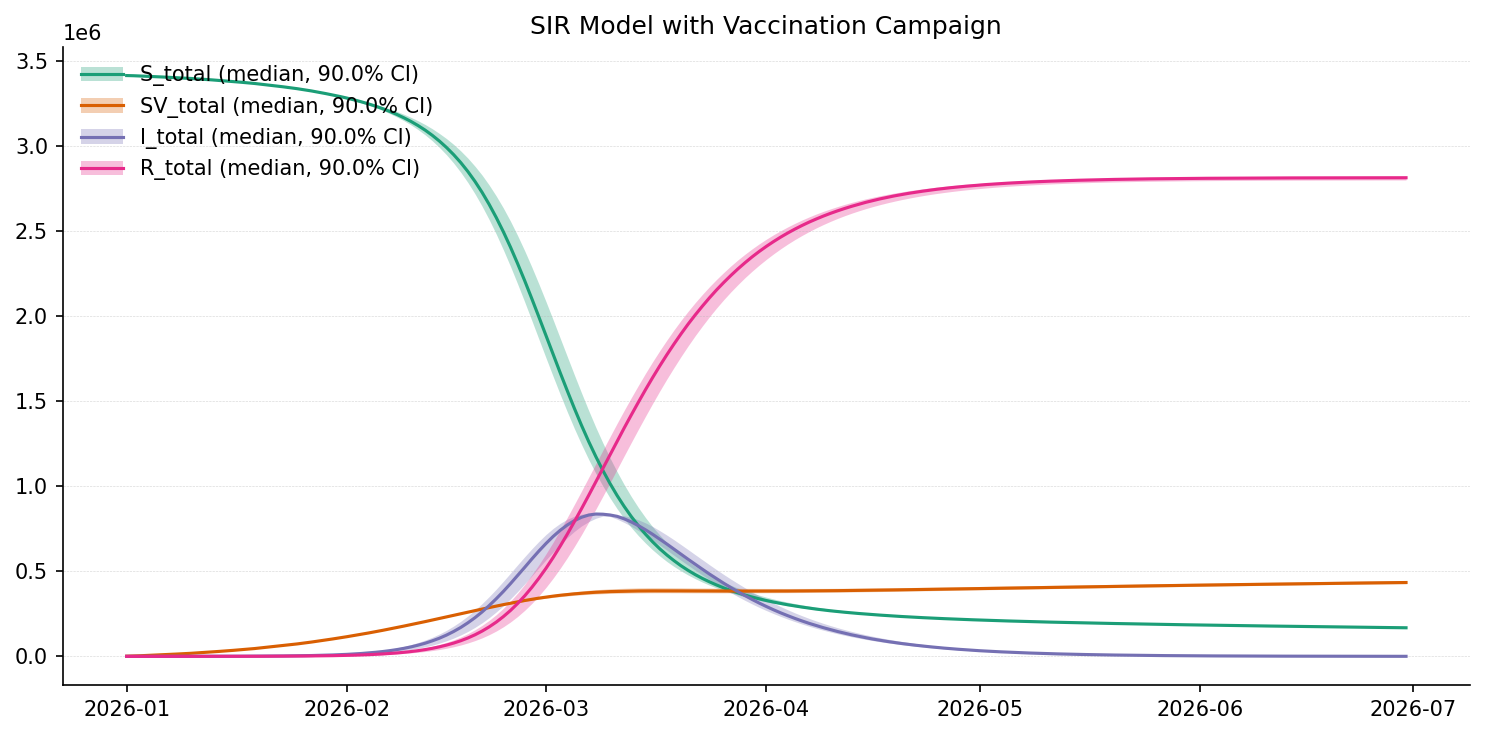

In [27]:
# Plot compartment evolution
df_vax_quantiles = results_vax.get_quantiles_compartments()

fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
plot_quantiles(df_vax_quantiles, 
               columns=["S_total", "SV_total", "I_total", "R_total"],
               title="SIR Model with Vaccination Campaign", ax=ax)

<Axes: title={'center': 'Vaccinated Susceptibles by Age Group'}>

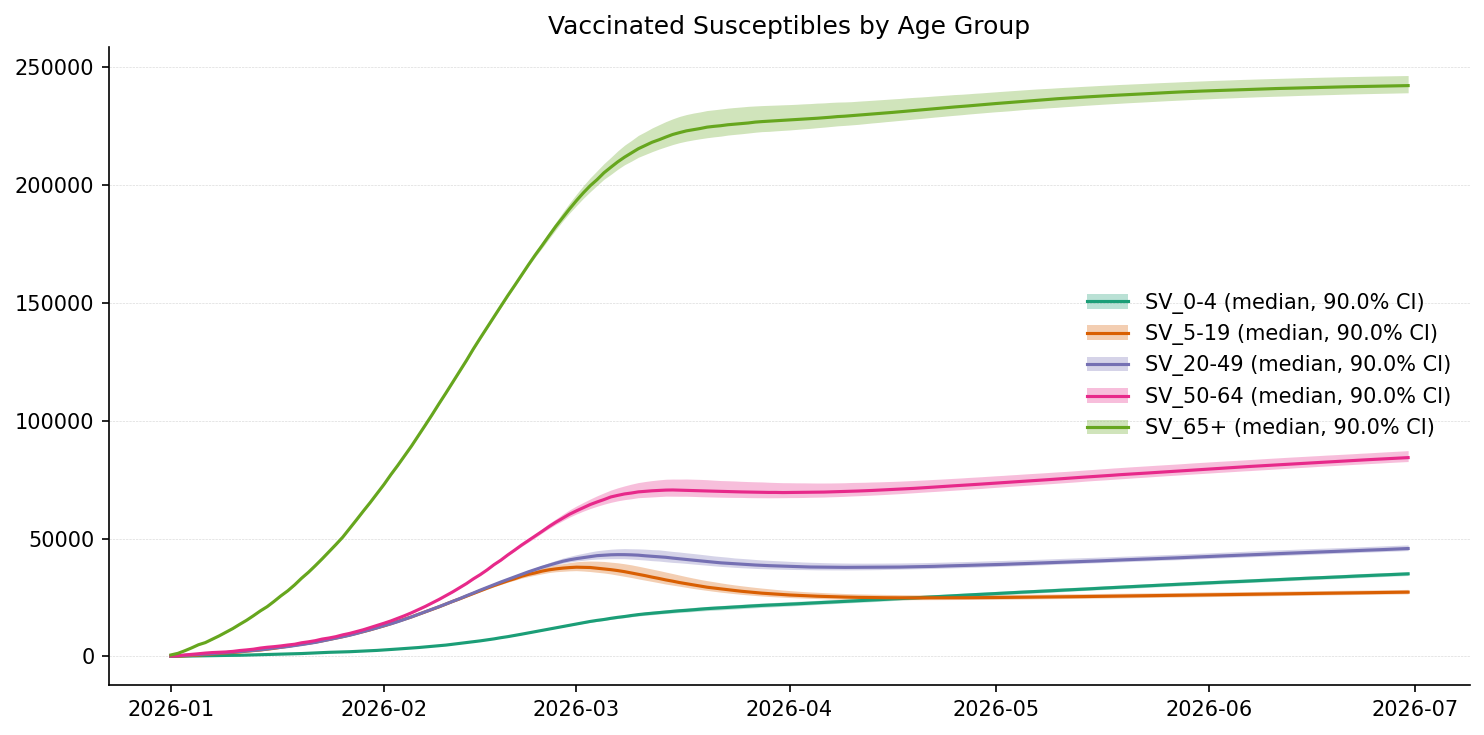

In [28]:
# Vaccinated individuals by age group
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
plot_quantiles(df_vax_quantiles,
               columns=["SV_0-4", "SV_5-19", "SV_20-49", "SV_50-64", "SV_65+"],
               title="Vaccinated Susceptibles by Age Group", ax=ax, legend_loc="center right")

---
## Resources

- [Epydemix Documentation](https://epydemix.readthedocs.io/)
- [Full Tutorial Series](https://github.com/epistorm/epydemix/tree/main/tutorials)
- [Supported Geographies](https://github.com/epistorm/epydemix-data/blob/main/locations.csv)